### Недообучение и переобучение

#### Цель работы

Познакомиться с основными проблемами обобщающей способности алгоритмов машинного обучения: overfitting (переобучение) и underfitting (недообучение).

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

1) Загрузите первые 400 строк прилагающегося датасета diabetes.csv.
2) Сделайте количественное описание датасета: число признаков, статистику по признакам.
3) Отделите целевую переменную Outcome.

In [11]:
data = pd.read_csv('diabetes.csv')
X = data.drop(columns=['Outcome'])  # Все признаки, кроме 'Outcome'
y = data['Outcome']  # Целевая переменная 'Outcome'

num_features = X.shape[1]  # Число признаков
feature_statistics = X.describe()  # Статистика по признакам

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### Диагностика моделей классификации

Для первого примера воспользуемся синтетическими данными. Сгенерируем большой датасет для классификации. В нем будет 10 тысяч точек и 500 атрибутов. Из них всего 50 признаков будут информативными. Сразу после генерации разделим получившийся датасет на обучающую и тестовую выборки:


In [12]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=500,
                           n_informative=50, n_repeated=0,
                           class_sep=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

Обучим на этом наборе данных модель логистическую регрессию. Выведем оценки точности этой модели на обучающей и тестовой выборке:

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.8415
Test score: 0.8056


То, насколько отличается обучающая и тестовая эффективность модели - основной индикатор пере- или недообучения. Тестовая эффективность полученной модели неидеальна. Определить, что является причиной снижения качества модели - ее излишняя или недостаточная вариативность - основная цель диагностики модели машинного обучения.

Применим построение кривых обучения. Это даст нам больше информации о том, каков уровень сложности модели по отношению к данным. Воспользуемся готовой реализацией построения кривых обучения из библиотеки продвинутой визуализации для машинного обучения yellowbrick:

/Users/juliamekhtieva/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


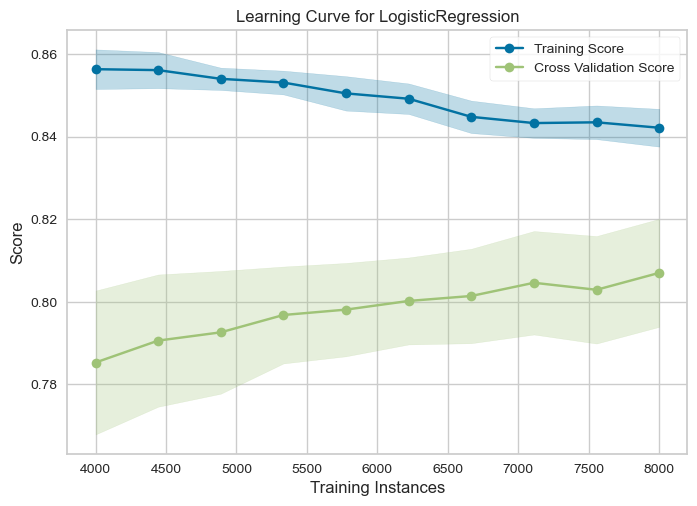

In [16]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(
    LogisticRegression(), train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show()

Задаем модель, которую необходимо проверить и набор долей обучающей выборки. В данном случае, эта функция построит модели логистической регрессии, обученные на 10%, 20%, и так далее до 100% обучающей выборки. А затем по каждой модели будет вычислена обучающая и тестовая эффективности. И эти показатели будут изображены на графике, то есть кривой обучения.

Эта кривая показывает, что когда модель учится на небольшом объеме данных, она имеет прекрасную обучающую эффективность, но плохую тестовую. По мере увеличения объема обучающей выборки, эти эффективности сближаются, но между ними все еще сохраняется зазор.

Большой промежуток между тестовой и обучающей эффективностью свидетельствует о переобучении. А низкое значение обучающей эффективности - о недообучении. 

Воспользуемся классификатором на основе гребневой регрессии. Обычный метод наименьших квадратов (воплощением которого является модель логистической регрессии) эквивалентна гребневой модели с параметром регуляризации, равном нулю. Чем больше этот параметр, тем больше регуляризации в модели и тем проще получаемые модели.

При таком огромном значении регуляризации почти гарантированно получим недообученную модель.


In [18]:
from sklearn.linear_model import RidgeClassifier

lr = RidgeClassifier(alpha=1000000).fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.7724
Test score: 0.7712


Эффективность стала заметно ниже, значения почти совпадают - почти никакой разницы. Это подтверждает первоначальный вывод о том, что в первой модели разница между обучающей и тестовой эффективностью получилась довольно большой для данной задачи. Построим кривые обучения для нашей второй модели:

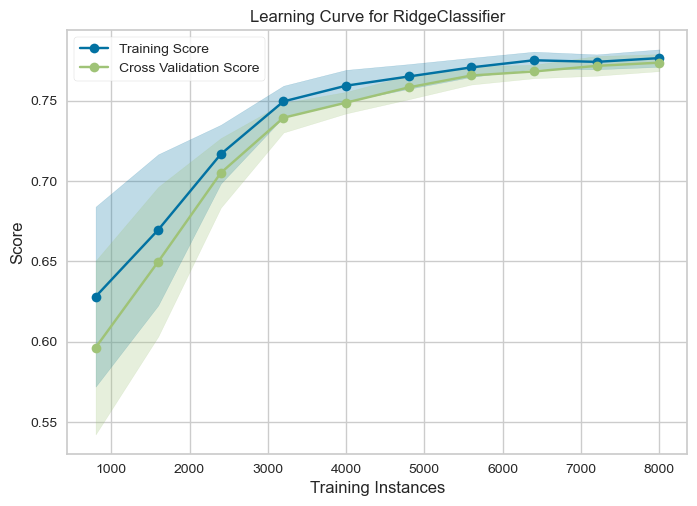

In [20]:
visualizer = LearningCurve(
    RidgeClassifier(alpha=1000000), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y) .show()

Данный график очень характерен для недообучения - низкие значения эффективности и практически никакой разницы между тестовой и обучающей эффективностью.

Построим график зависимости эффективности модели от значения параметра регуляризации. Для этого воспользуется логравномерным распределением:

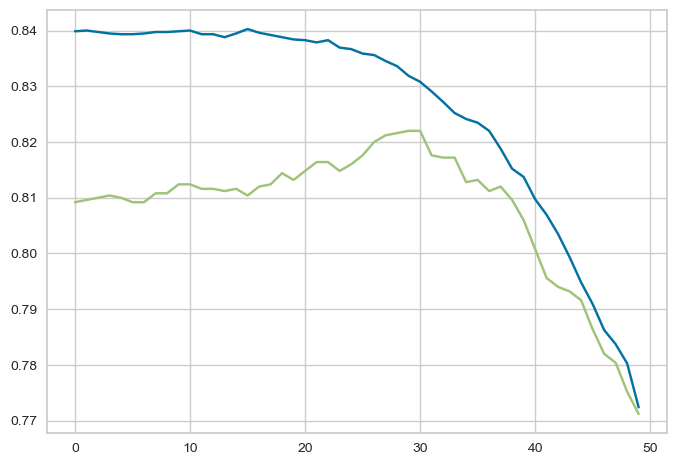

In [21]:
from sklearn.linear_model import RidgeClassifier
trains = []
tests = []
for i in np.logspace(2, 6, 50):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains)
plt.plot(tests)

Данный код построит 50 моделей, различающихся только параметром регуляризации. Диапазон подбирается эмпирически. При определенных значениях параметра регуляризации тестовая эффективность модели лучше. Подбором или алгоритмически можно найти такое оптимальное значение параметра регуляризации. Оно дает нам модель, которая имеет оптимальный уровень сложности для данного конкретного датасета.

In [24]:
lr = RidgeClassifier(alpha=26500).fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.8311
Test score: 0.8228


### Диагностика моделей регрессии


In [3]:
# Датасет цен на недвижимость

from numpy import genfromtxt
from sklearn.model_selection import train_test_split

dataset = genfromtxt('https://raw.githubusercontent.com/m-mehdi/tutorials/main/boston_housing.csv', delimiter=',')
X = dataset[:,:-1]
y = dataset[:,-1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

Это набор данных для решения задачи регрессии - предсказания цен объектов недвижимости по их характеристикам. Выведем оценку эффективности простой модели - линейной регрессии:

In [6]:
from sklearn.linear_model import LinearRegression

# Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Оценка модели на обучающем наборе
train_score = model.score(X_train, y_train)
print("Linear Regression - Оценка на обучающем наборе:", train_score)

# Оценка модели на тестовом наборе
test_score = model.score(X_test, y_test)
print("Linear Regression - Оценка на тестовом наборе:", test_score)

Linear Regression - Оценка на обучающем наборе: 0.9520519609032729
Linear Regression - Оценка на тестовом наборе: 1.0


Большой разрыв между обучающей и тестовой эффективностью -> переобучение данной модели. Проверим предположение при помощи кривых обучения (используем гребневую модель с очень маленькой регуляризацией).

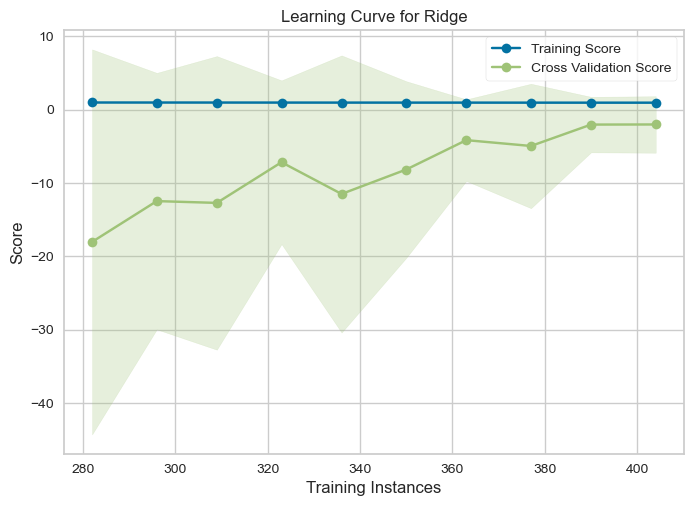

In [8]:
from sklearn.linear_model import Ridge
from yellowbrick.model_selection import LearningCurve
visualizer = LearningCurve(
    Ridge(alpha=0.0001), scoring='r2', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X, y) .show() 

Построим график зависимости эффективности модели от значения параметра L2-регуляризации:

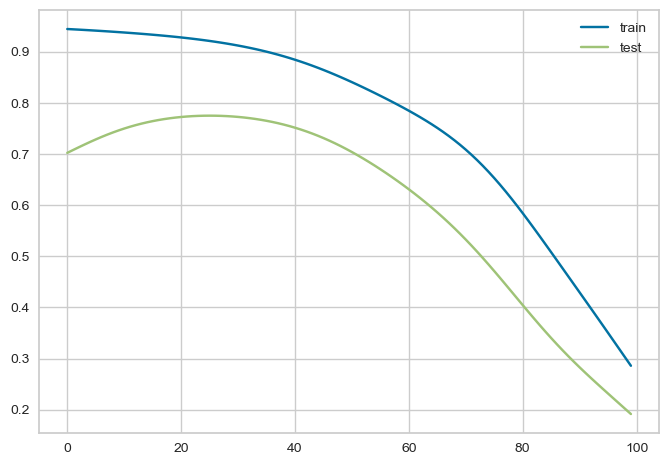

In [11]:
trains = []
tests = []

for alpha in np.logspace(-2, 3, 100):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()
plt.show()

На этом графике очень наглядно виден характер кривых регуляризации. В левой области лежат значения, которые дают слишком сложные модели. Они хорошо описывают обучающую выборку, но не обобщаются на тестовую. Это зона переобучения. В правой области - значения, порождающие слишком простые модели. Они одинаково плохо описывают и обучающую и тестовые выборки. Это зона недообучения. Посередине между ними лежит оптимальный уровень сложности модели для данного конкретного датасета. Здесь эта оптимальность очень хорошо выражена.

Численно можно подобрать оптимальное значение параметра регуляризации для гребневой регрессии, выведем эффективность такой оптимальной модели:

In [12]:
lr = Ridge(alpha=0.18).fit(X_train, y_train)

print(f"Linear Regression-Training set score: {lr.score(X_train, y_train):.2f}")
print(f"Linear Regression-Test set score: {lr.score(X_test, y_test):.2f}")

Linear Regression-Training set score: 0.92
Linear Regression-Test set score: 0.77


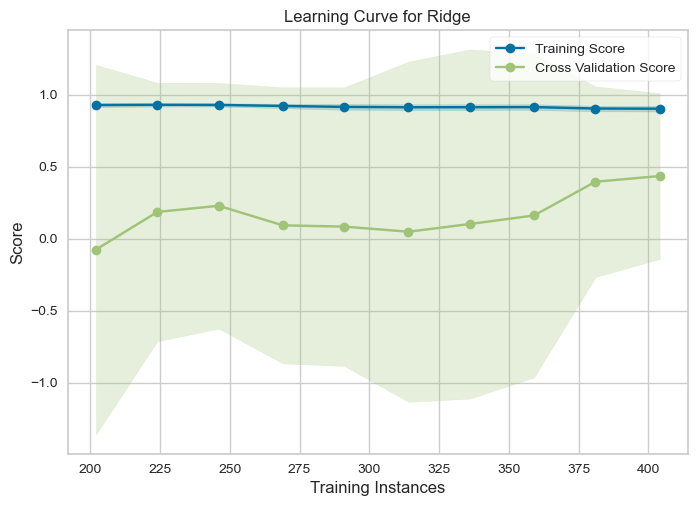

In [13]:
visualizer = LearningCurve(
    Ridge(alpha=0.18), scoring='r2', train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y) .show() 

Здесь можно заметить, что несмотря на то, что подобран наилучший уровень сложности модели, ее эффективность все равно не идеальна. Присутствует и разница между тестовой и обучающей эффективностью. Это свидетельствует о том, что и в нашей самой лучшей модели все равно имеется и bias и variance в какой-то степени. 

Можно исследовать на этом же датасете и другие модели. Попробуем другой вид регуляризации - лассо. В библиотеке sklearn эта модель работает только как регрессор, то есть она не подходит для задач классификации. Построим кривые регуляризации:

/Users/juliamekhtieva/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.440e+02, tolerance: 3.233e+00
  model = cd_fast.enet_coordinate_descent(
/Users/juliamekhtieva/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.449e+02, tolerance: 3.233e+00
  model = cd_fast.enet_coordinate_descent(
/Users/juliamekhtieva/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

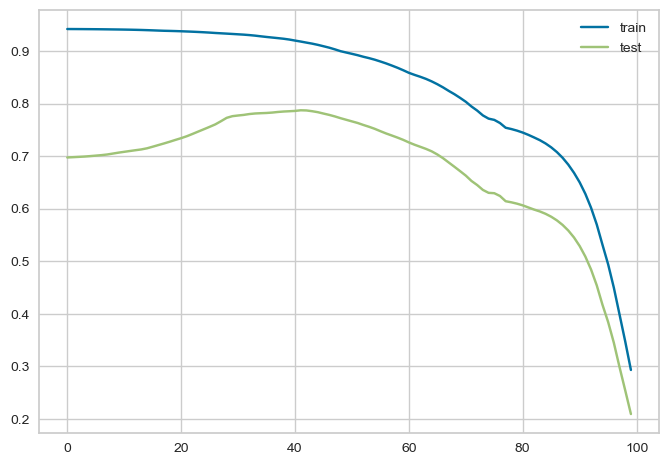

In [14]:
from sklearn.linear_model import Lasso
trains = []
tests = []
for i in np.logspace(-4, 0, 100):
    ridge = Lasso(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()

Точно также можно исследовать и другие виды моделей. Итого для диагностики моделей используется три инструмента:

- сравнение обучающей и тестовой эффективности
- анализ формы кривых обучения
- построение кривых по одному из гиперпараметров модели, который влияет на соотношение bias/variance
Главное - это сравнение между собой нескольких моделей одного типа, но с разным уровнем сложности.

### Диагностика на реальных данных

In [41]:
import pandas as pd
df = pd.read_csv('diabetes.csv',nrows=200) #имитируем обучение на части данных выбрав только 200 строк
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [16]:
# Формируем обучающую и тестовую выборки
target = "Outcome"
y = df[target]
X = df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Для моделирования выберем тип модели решающие деревья. Создадим объект модели дерева решений и исследуем его эффективность:

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 1.0000
Test score = 0.5500


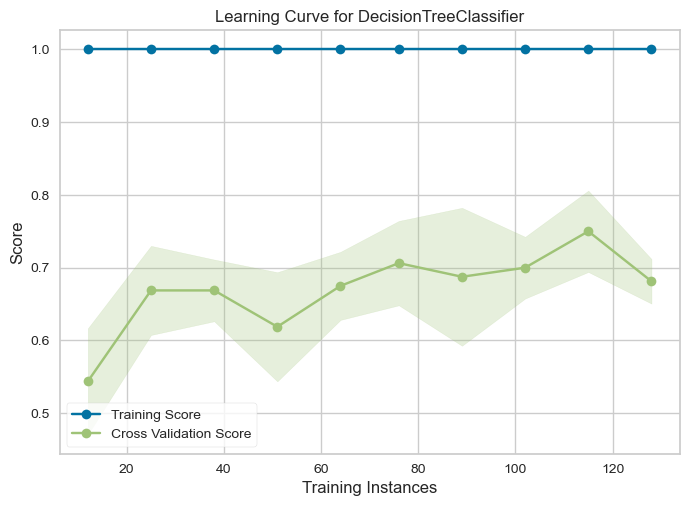

<Axes: title={'center': 'Learning Curve for DecisionTreeClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [21]:
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.model_selection import LearningCurve

# Создание объекта модели решающих деревьев
model = DecisionTreeClassifier(random_state=1)

# Создание объекта LearningCurve и отображение кривой обучения
visualizer = LearningCurve(
    model, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=1)

visualizer.fit(X_train, y_train)
visualizer.show()

У деревьев решений один из параметров - максимальная глубина дерева как раз и влияет на склонность модели к переобучению. Аналогом регуляризации для деревьев будет искусственное ограничение максимальной глубины дерева. Построим кривую обучения для такого регуляризованного дерева:

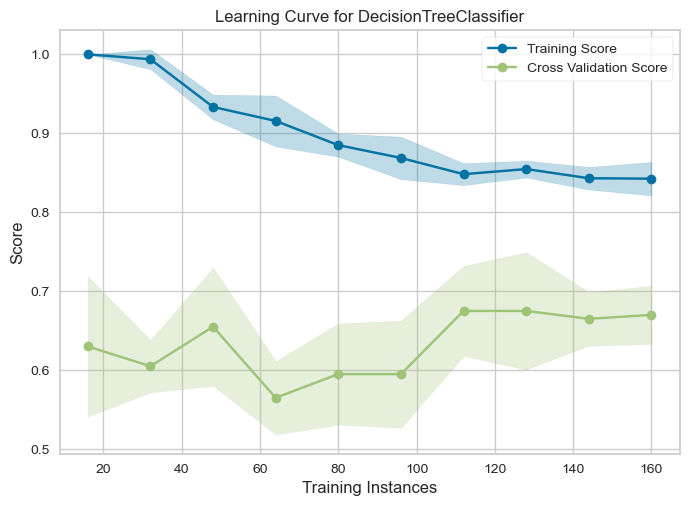

In [22]:
visualizer = LearningCurve(
    DecisionTreeClassifier(max_depth=4), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y) .show()

Введение регуляризации, искусственное упрощение моделей - не единственный способ борьбы с переобучением. Самый лучший способ - это обучение на более полном датасете, то есть добавление большого количества данных. Повторим обучение нерегуляризованного дерева решений на всем датасете.

In [40]:
df = pd.read_csv('diabetes.csv')
target = "Outcome"
y = df[target]
X = df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
from sklearn.metrics import f1_score
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 1.0000
Test score = 0.7273


Получившаяся модель значительно лучше, чем даже регуляризованное дерево. В общем случае, добавление данных работает лучше, чем регуляризация.

### Диагностика недообучения

В sklearn есть встроенный механизм загрузки датасетов из онлайн репозитория OpenML. Возьмем оттуда датасет, посвященный проблеме управления истребителем F16:

In [26]:
from sklearn.datasets import fetch_openml
data = fetch_openml(name='delta_ailerons', parser="auto")
data.data.shape

/Users/juliamekhtieva/anaconda3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:91: UserWarning: A network error occurred while downloading https://openml.org/api/v1/json/data/list/data_name/delta_ailerons/limit/2/status/active/. Retrying...
  warn(


(7129, 5)

In [28]:
# Сформируем обучающую и тестовую выборки:

X = pd.get_dummies(data.data)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:
# Создадим и оценим простую модель логистической регрессии

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.6058
Test score = 0.5940


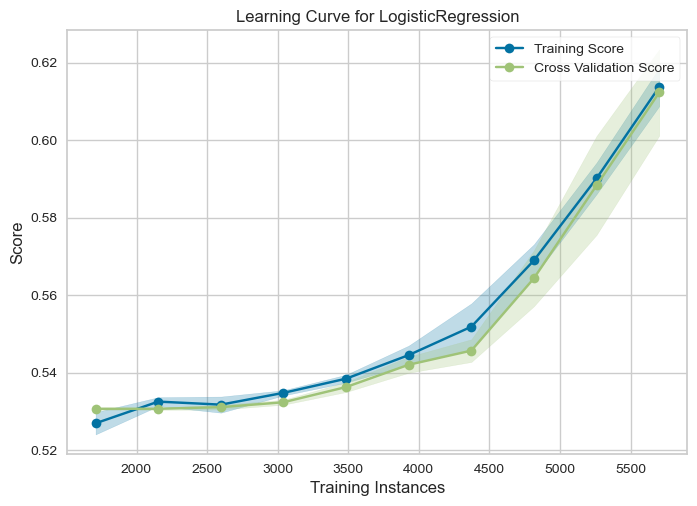

In [34]:
# Построим кривую обучения данной модели:

visualizer = LearningCurve(
    LogisticRegression(), scoring='accuracy', train_sizes=np.linspace(0.3, 1.0, 10)
).fit(X, y) .show()

Здесь очевидны признаки недообучения: низкий уровень обучающей эффективности, малый разрыв между обучающей и тестовой эффективностью. При недообучении регуляризация не поможет, даже навредит, так как еще усилит его. Поэтому единственный путь в этом случае - использовать более сложные, вариативные модели. Можно, например, попробовать многослойный перцептрон:

In [35]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.9388
Test score = 0.9404


/Users/juliamekhtieva/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
